In [ ]:
'''Steps-
Importing necessary libraries
Reading the dataset
EDA and Missing Values Check
Data Preprocessing:
1)Encoding the target variable.
2)Cleaning and preprocessing the text data.
Text Tokenization and Padding:
1)Converting the text data into sequences of integers.
2)Padding these sequences to ensure uniform length.
Building and Training the LSTM Model:
1)Creating an LSTM model.
2)Compiling and training the model on the training data.
Evaluate the Model:
1)Making predictions on the test data.
2)Evaluating the model's performance.
Model Deployment'''

In [ ]:
#problem-what emotion is directed towards which product! 
'''Introduction- This project uses natural language processing and sentiment analysis, aiming to understand consumer sentiments
towards the given products. The system utilizes Long Short-Term Memory (LSTM) neural networks, a type of recurrent neural network
(RNN), to learn patterns from 'tweet_text' data and predict suitable 'emotion'.(Here, Y or target feature is 'is_there_an_emotion_directed_at_a_brand_or_product' column)'''

In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

In [2]:
# Loading the dataset
train_df = pd.read_excel('ML Assignment Dataset.xlsx', sheet_name='Train')

In [3]:
test_df = pd.read_excel('ML Assignment Dataset.xlsx', sheet_name='Test')


In [4]:
#To view first 5 rows of train_df
print(train_df.head())

#Exploratory Data Analysis
# Basic information about the datasets
print("Train Dataset Info:")
print(train_df.info())
print("\nTest Dataset Info:")
print(test_df.info())

# Descriptive statistics
print("\nTrain Dataset Description:")
print(train_df.describe(include='all'))
print("\nTest Dataset Description:")
print(test_df.describe(include='all'))

# Checking for missing values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())

                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (to

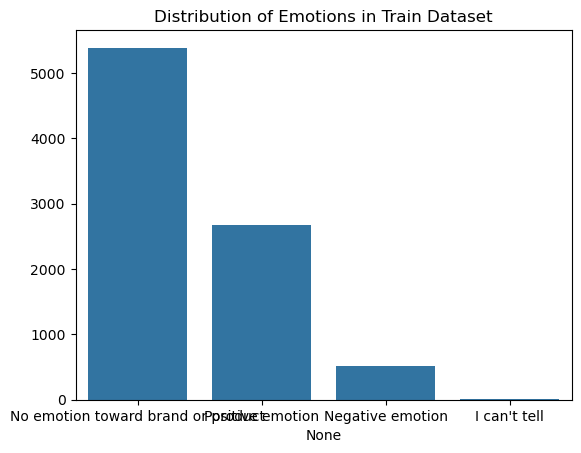

In [5]:
#Visualization
# Distribution of the target variable (if applicable)
emotion_counts = train_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Distribution of Emotions in Train Dataset")
plt.show()

#'No emotion toward brand' contributes the highest emotion, 'negative emotion' contributes least in the dataset and 'I can't tell' contributing negligible count.

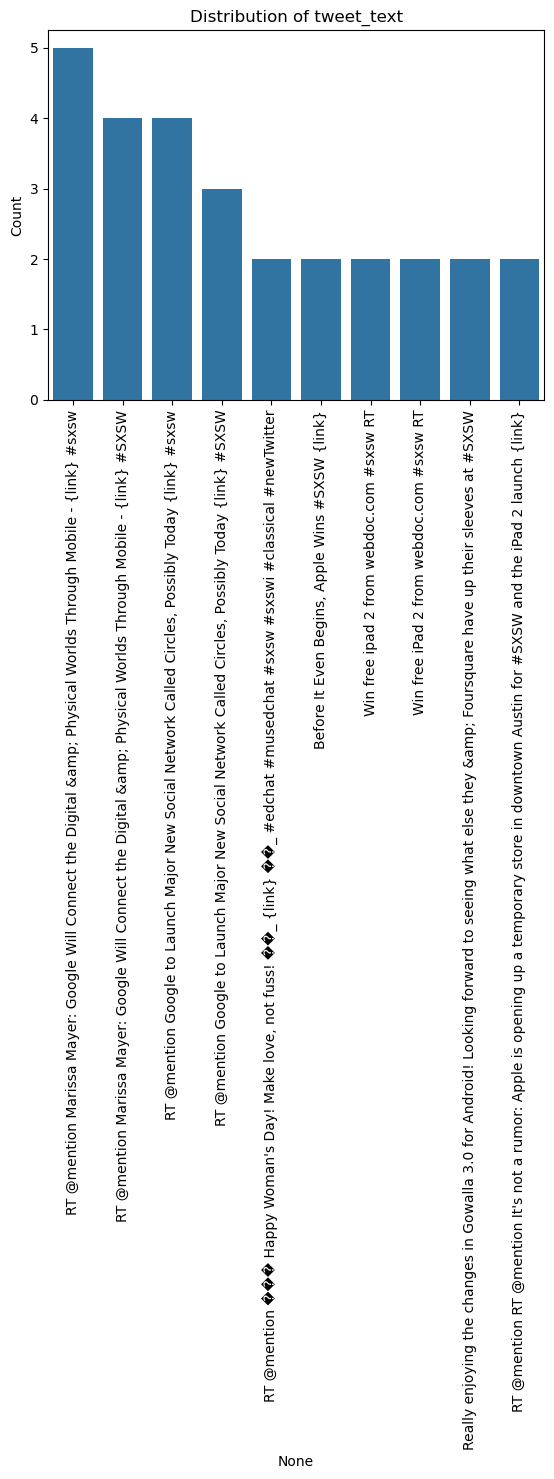

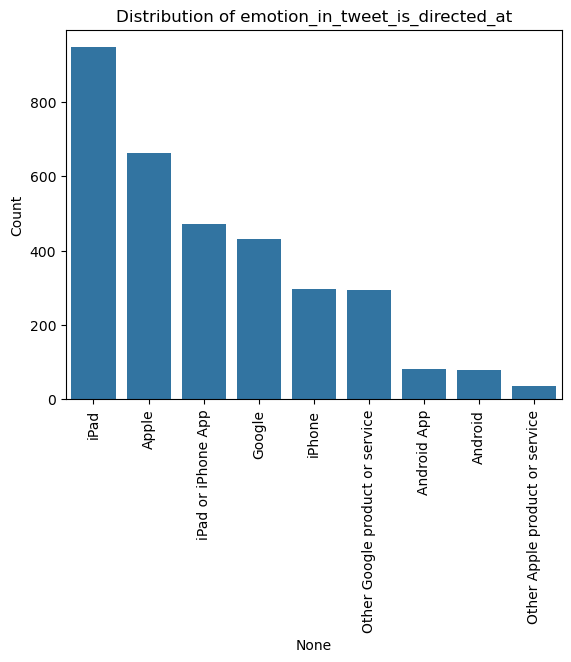

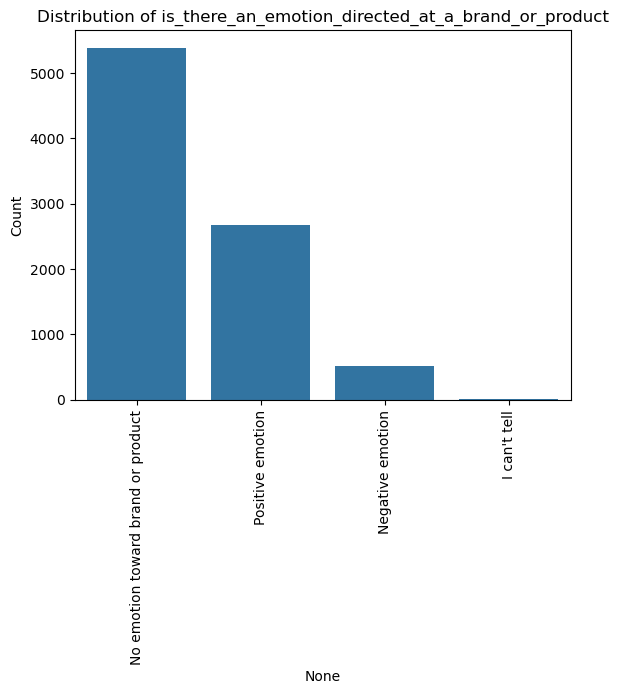

In [6]:
# Distribution of categorical features
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# As train_df is my DataFrame
categorical_features = train_df.select_dtypes(include=['object']).columns

for feature in categorical_features:
    # Calculating the counts of each category
    counts = train_df[feature].value_counts()

    # Handling high cardinality: hence we choose to display only the top 10 categories
    top_categories = counts.head(10)  # Adjusting the number as needed

    # Creating a bar plot
    sns.barplot(x=top_categories.index, y=top_categories.values)
    
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.show()
    
#showing the top 10 features from highest to lowest.   


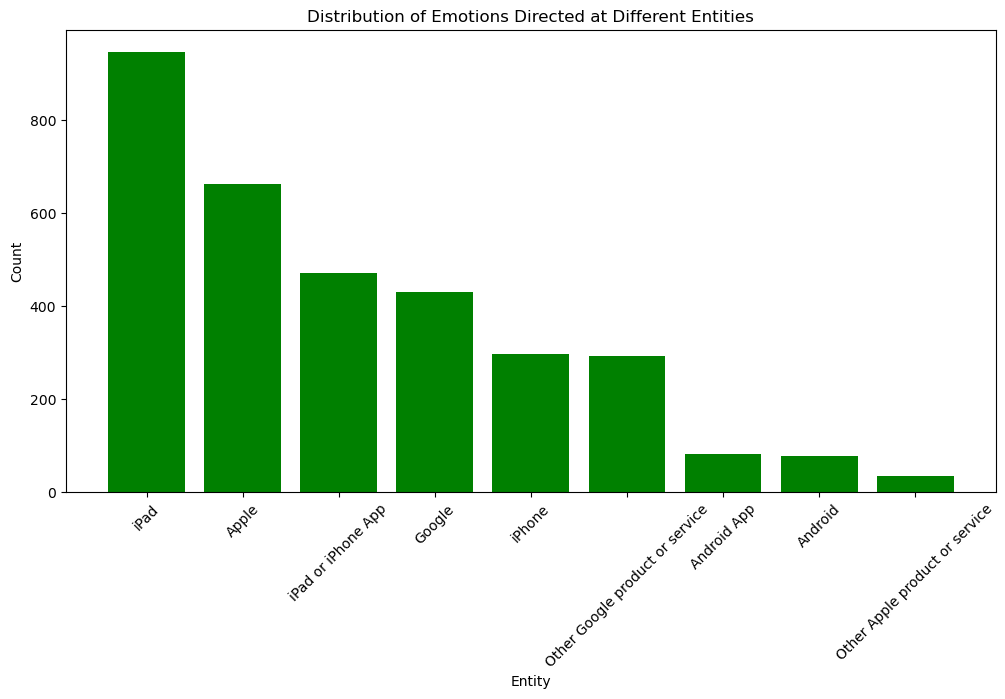

In [7]:
#Distribution of 'emotion_in_tweet_is_directed_at':

# Calculating the counts of each category for 'emotion_in_tweet_is_directed_at'
directed_emotion_counts = train_df['emotion_in_tweet_is_directed_at'].value_counts()

# Creating a bar plot
plt.figure(figsize=(12, 6))
plt.bar(directed_emotion_counts.index, directed_emotion_counts.values, color='green')

# Adding title and labels
plt.title("Distribution of Emotions Directed at Different Entities")
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Showing the plot
plt.show()


#Most emotions are directed at iPads, Apple products, and Google products.

In [8]:
# Checking for missing values in the Train sheet
missing_values_train = train_df.isnull().sum()
print("Missing Values in Train Sheet:")
print(missing_values_train)

# Checking for missing values in the Test sheet
missing_values_test = test_df.isnull().sum()
print("\nMissing Values in Test Sheet:")
print(missing_values_test)

# train_df - tweet_text contains 1 missing value,emotion_in_tweet_is_directed_at contains highest missing values that is 5298 and column is_there_an_emotion_directed_at_a_brand_or_product has no missing values.
# test_df has no missing values

Missing Values in Train Sheet:
tweet_text                                               1
emotion_in_tweet_is_directed_at                       5298
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Missing Values in Test Sheet:
Tweet    0
dtype: int64


In [9]:
# Parameters for tokenization and padding
vocab_size = 10000
oov_tok = "<OOV>"
max_length = 120
padding_type = 'post'
trunc_type = 'post'


# Filling missing values
train_df.fillna('', inplace=True)  # Assuming empty string for missing values

# Data cleaning function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Cleaning and preprocessing
train_df['cleaned_tweet_text'] = train_df['tweet_text'].apply(clean_text)

# Preparing the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['cleaned_tweet_text'])
sequences = tokenizer.texts_to_sequences(train_df['cleaned_tweet_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Preparing the target variable
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_df['is_there_an_emotion_directed_at_a_brand_or_product'])

# Splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, encoded_labels, test_size=0.2, random_state=42
)

# Building an LSTM model
lstm_model = Sequential([
    Embedding(vocab_size, 16, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(4, activation='softmax')  # Adjusted to 4 for the number of label classes
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=2)

# Evaluate the model on the validation set
val_loss, val_accuracy = lstm_model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


#Validation Accuracy: 61.64%
#Further accuracy can be improved by making changes in epochs and batch size.

Epoch 1/10
108/108 - 32s - loss: 0.8947 - accuracy: 0.6242 - val_loss: 0.8354 - val_accuracy: 0.6164 - 32s/epoch - 299ms/step
Epoch 2/10
108/108 - 22s - loss: 0.8350 - accuracy: 0.6302 - val_loss: 0.8382 - val_accuracy: 0.6164 - 22s/epoch - 204ms/step
Epoch 3/10
108/108 - 26s - loss: 0.8365 - accuracy: 0.6302 - val_loss: 0.8345 - val_accuracy: 0.6164 - 26s/epoch - 238ms/step
Epoch 4/10
108/108 - 24s - loss: 0.8358 - accuracy: 0.6302 - val_loss: 0.8342 - val_accuracy: 0.6164 - 24s/epoch - 226ms/step
Epoch 5/10
108/108 - 24s - loss: 0.8349 - accuracy: 0.6302 - val_loss: 0.8342 - val_accuracy: 0.6164 - 24s/epoch - 225ms/step
Epoch 6/10
108/108 - 25s - loss: 0.8345 - accuracy: 0.6302 - val_loss: 0.8376 - val_accuracy: 0.6164 - 25s/epoch - 232ms/step
Epoch 7/10
108/108 - 32s - loss: 0.8360 - accuracy: 0.6302 - val_loss: 0.8421 - val_accuracy: 0.6164 - 32s/epoch - 298ms/step
Epoch 8/10
108/108 - 26s - loss: 0.8339 - accuracy: 0.6302 - val_loss: 0.8336 - val_accuracy: 0.6164 - 26s/epoch - 242

In [10]:
'''Here in our use case, we are dealing with a multiclass classification problem and we do not have actual labels in our test sheet, 
our code is already appropriate for generating predictions. However, we won't be able to evaluate the model's performance 
without the actual labels. Hence considered a part of data as validation set from training set''' 

"Here in our use case, we are dealing with a multiclass classification problem and we do not have actual labels in our test sheet, \nour code is already appropriate for generating predictions. However, we won't be able to evaluate the model's performance \nwithout the actual labels. Hence considered a part of data as validation set from training set"

In [11]:
#General model deployment process or we can also use Flask instead of this for deployment.

In [12]:
#Saving the Trained Model and Tokenizer
# Saving the LSTM model
lstm_model.save('sentiment_lstm_model.h5')

# Saving the tokenizer and label encoder
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as enc_handle:
    pickle.dump(label_encoder, enc_handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#Step 2: Loading the Model, Tokenizer, and Label Encoder for Inference

from tensorflow.keras.models import load_model
import pickle

# Loading the saved model
model = load_model('sentiment_lstm_model.h5')

# Loading the tokenizer and label encoder
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('label_encoder.pickle', 'rb') as enc_handle:
    label_encoder = pickle.load(enc_handle)


In [ ]:
#Step 3: Preprocessing New Input Data

def preprocess_text(text):
    text = clean_text(text)  # Use the same clean_text function from earlier
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    return padded


In [ ]:
#Step 4: Making Predictions
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

# For Example
tweet = "your tweet here"
print(predict_sentiment(tweet))

